In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

In [13]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [7]:
redshift_estimator_name = 'kNN'
save_tag_model = f'_K11'
fn_spz_labeled = f'../data/redshift_estimates/redshifts_spz_labeled_{redshift_estimator_name}{save_tag_model}.fits'
tab_spz_labeled = utils.load_table(fn_spz_labeled)
print(f"N = {len(tab_spz_labeled)}")
print(tab_spz_labeled.columns)

N = 245308
<TableColumns names=('source_id','z_sdss','phot_g_mean_mag','redshift_qsoc','rand_ints','redshift_spz_raw','redshift_spz_err')>


In [5]:
rand_ints_labeled = tab_spz_labeled['rand_ints']
# N_tot=N_gaia because the numbers go up to all the ones in the clean catalog
i_train, i_valid, i_test = utils.split_train_val_test(rand_ints_labeled,
                                 frac_train=0.7, frac_val=0.15, frac_test=0.15)

In [25]:
z_sdss_valid = tab_spz_labeled['z_sdss'][i_valid]
z_spzraw_valid = tab_spz_labeled['redshift_spz_raw'][i_valid]
z_gaia_valid = tab_spz_labeled['redshift_qsoc'][i_valid]

In [71]:
dz_spzraw_gaia = (z_spzraw_valid - z_gaia_valid)/(1+z_gaia_valid)
dz_spzraw_sdss = (z_spzraw_valid - z_sdss_valid)/(1+z_sdss_valid)
dz_gaia_sdss = (z_gaia_valid - z_sdss_valid)/(1+z_sdss_valid)


In [26]:
z_bins = np.linspace(0,np.max(z_qsoc_valid),100)

Text(0, 0.5, '$z_\\mathrm{\\textit{Gaia}}$, Gaia redshift')

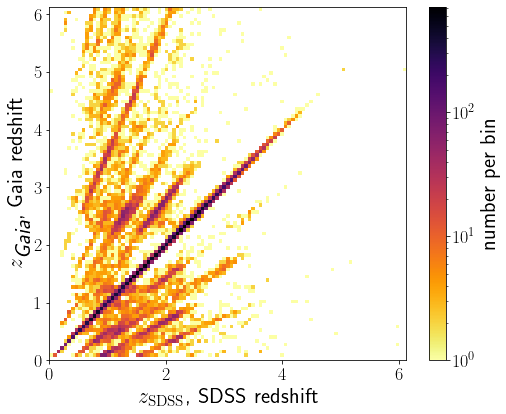

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_valid, z_gaia_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')

Text(0, 0.5, '$z_\\mathrm{SPZraw}$, spectro-photometric redshift')

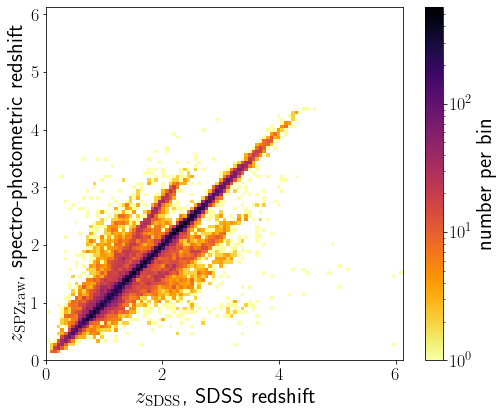

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_sdss_valid, z_spzraw_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{SDSS}$, SDSS redshift')
plt.ylabel(r'$z_\mathrm{SPZraw}$, spectro-photometric redshift')

Text(0, 0.5, '$z_\\mathrm{SPZraw}$, spectro-photometric redshift')

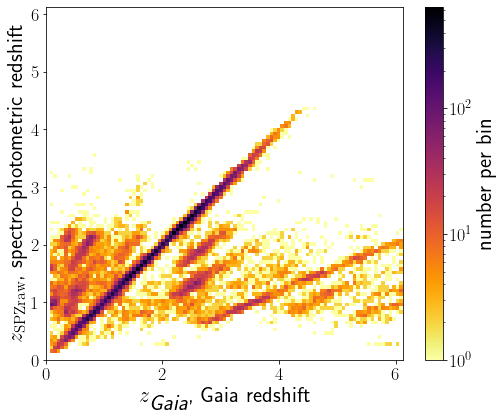

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_gaia_valid, z_spzraw_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')
plt.ylabel(r'$z_\mathrm{SPZraw}$, spectro-photometric redshift')

Text(0.5, 0, '$|z_\\mathrm{SPZraw}-z_\\mathrm{Gaia}|/(1+z_\\mathrm{Gaia})$')

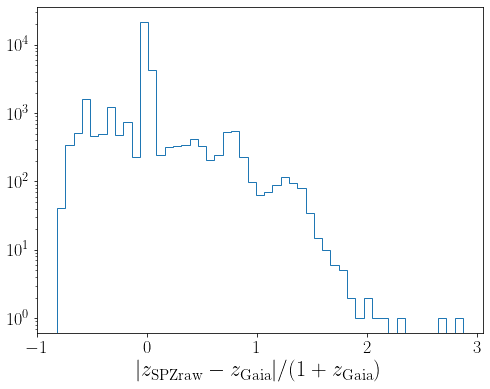

In [36]:
dz_bins = np.linspace(np.min(dz_spzraw_gaia), np.max(dz_spzraw_gaia), 50)

plt.figure(figsize=(8,6))
plt.hist(dz_spzraw_gaia, bins=dz_bins, histtype='step')
plt.yscale('log')

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')

Text(0.5, 0, '$|z_\\mathrm{SPZraw}-z_\\mathrm{Gaia}|/(1+z_\\mathrm{Gaia})$')

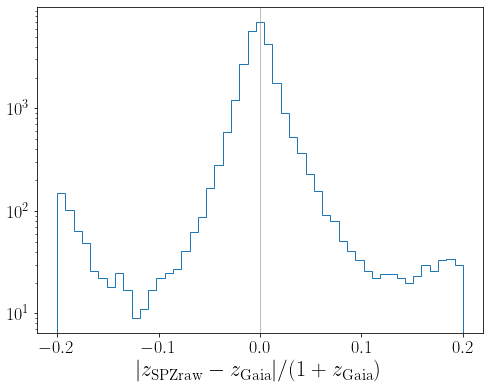

In [38]:
dz_bins = np.linspace(-0.2, 0.2, 50)

plt.figure(figsize=(8,6))
plt.hist(dz_spzraw_gaia, bins=dz_bins, histtype='step')
plt.yscale('log')

plt.axvline(0.0, color='grey', lw=0.5)

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')

Text(0.5, 0, '$|z_\\mathrm{SPZraw}-z_\\mathrm{Gaia}|/(1+z_\\mathrm{Gaia})$')

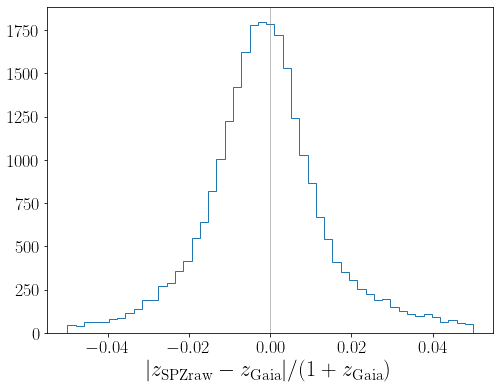

In [65]:
dz_bins = np.linspace(-0.05, 0.05, 50)

plt.figure(figsize=(8,6))
plt.hist(dz_spzraw_gaia, bins=dz_bins, histtype='step')
#plt.yscale('log')

plt.axvline(0.0, color='grey', lw=0.5)

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')

Text(0, 0.5, '$|z_\\mathrm{Gaia}-z_\\mathrm{SDSS}|/(1+z_\\mathrm{SDSS})$')

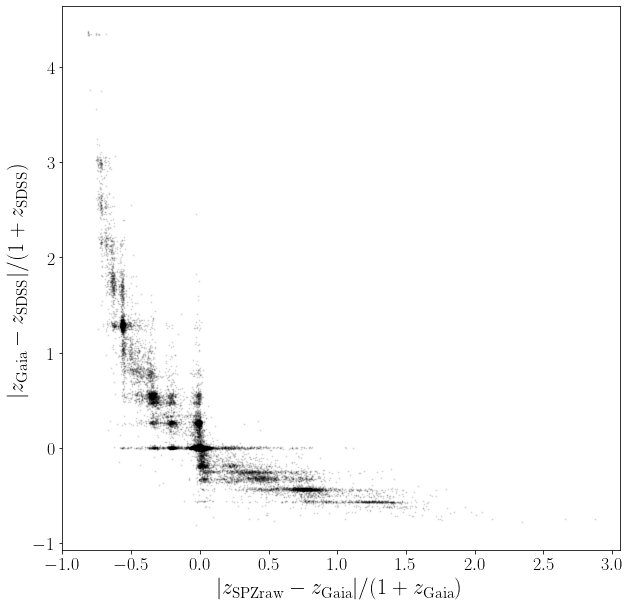

In [48]:
plt.figure(figsize=(10,10))
plt.scatter(dz_spzraw_gaia, dz_gaia_sdss, color='k', s=1, alpha=0.1)

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')
plt.ylabel(r'$|z_\mathrm{Gaia}-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')


0.6464561365365801


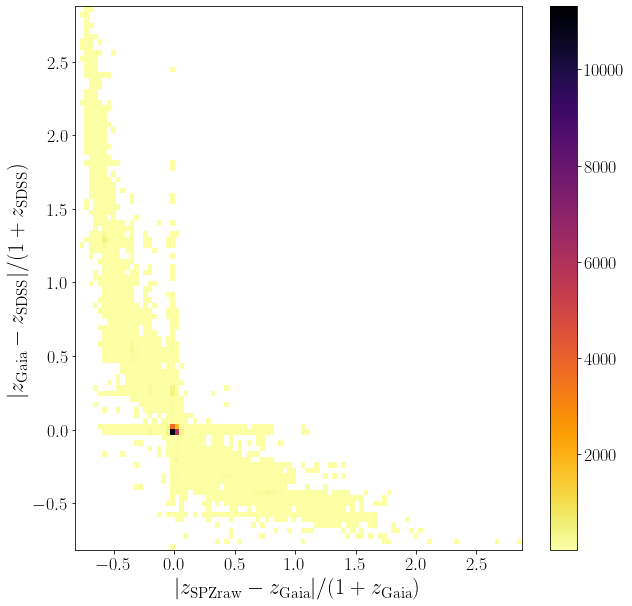

In [58]:
#dz_bins = np.linspace(-0.2, 0.2, 50)
dz_bins = np.linspace(np.min(dz_spzraw_gaia), np.max(dz_spzraw_gaia), 100)
plt.figure(figsize=(10,10))
plt.hist2d(dz_spzraw_gaia, dz_gaia_sdss, bins=dz_bins, cmin=1, cmap='inferno_r')
plt.colorbar()

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')
plt.ylabel(r'$|z_\mathrm{Gaia}-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')

i_spzraw_gaia_agree = (np.abs(dz_spzraw_gaia) < 0.1)
i_gaia_sdss_agree = (np.abs(dz_gaia_sdss) < 0.1)
print(np.sum(i_spzraw_gaia_agree & i_gaia_sdss_agree)/len(i_gaia_sdss_agree))

0.6464561365365801


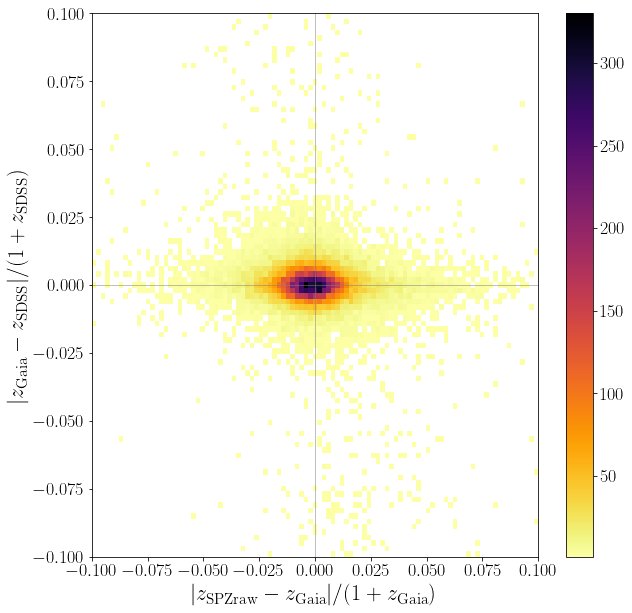

In [61]:
dz_bins = np.linspace(-0.1, 0.1, 100)
#dz_bins = np.linspace(np.min(dz_spzraw_gaia), np.max(dz_spzraw_gaia), 100)
plt.figure(figsize=(10,10))
plt.hist2d(dz_spzraw_gaia, dz_gaia_sdss, bins=dz_bins, cmin=1, cmap='inferno_r')
plt.colorbar()

plt.xlabel(r'$|z_\mathrm{SPZraw}-z_\mathrm{Gaia}|/(1+z_\mathrm{Gaia})$')
plt.ylabel(r'$|z_\mathrm{Gaia}-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')

plt.axvline(0.0, color='grey', lw=0.5)
plt.axhline(0.0, color='grey', lw=0.5)

i_spzraw_gaia_agree = (np.abs(dz_spzraw_gaia) < 0.1)
i_gaia_sdss_agree = (np.abs(dz_gaia_sdss) < 0.1)
print(np.sum(i_spzraw_gaia_agree & i_gaia_sdss_agree)/len(i_gaia_sdss_agree))

In [92]:
from scipy.stats import norm

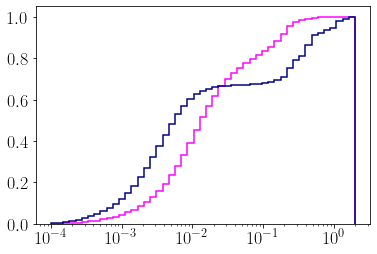

In [110]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)
# cdf_dz_spzraw, _ = np.histogram(dz_spzraw_sdss, bins=dz_bins_log, normed=True)
# cdf_dz_gaia, _ = np.histogram(dz_gaia_sdss, bins=dz_bins_log, normed=True)
# plt.plot(cdf_dz_spzraw)
# plt.plot(cdf_dz_gaia)
# plt.xscale('log')
h_spzraw, _, _ = plt.hist(abs(dz_spzraw_sdss), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='magenta', label=r'$z=z_\mathrm{SPZ}$')
h_gaia, _, _ = plt.hist(abs(dz_gaia_sdss), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw,
         color='navy', label=r'$z=z_\mathrm{Gaia}$')
plt.xscale('log')

In [121]:
dz_bins_log_avg = 10**(0.5*(np.log10(dz_bins_log[:-1]) + np.log10(dz_bins_log[1:])))
i_dz = (dz_bins_log_avg >= 1e-3) & (dz_bins_log_avg < 1e-1)
diffs = np.abs(h_spzraw[i_dz] - h_gaia[i_dz])
i_min = np.argmin(diffs)
dz_x = dz_bins_log_avg[i_dz][i_min]
print(dz_x, h_gaia[i_dz][i_min])

0.02593243899527689 0.6637160751565763


In [127]:
z_spzx_valid = z_spzraw_valid
i_usegaia_x = np.abs(dz_spzraw_gaia) < dz_x
print("Number of SPZ's we'll switch out for Gaia:", np.sum(i_usegaia_x), "out of", len(i_usegaia_x))
print(np.sum(i_usegaia_x)/len(i_usegaia_x))
z_spzx_valid[i_usegaia_x] = z_gaia_valid[i_usegaia_x]
dz_spzx_sdss = (z_spzx_valid - z_sdss_valid)/(1+z_sdss_valid)

Number of SPZ's we'll switch out for Gaia: 22979 out of 36796
0.6244972279595609


In [131]:
z_spzhi_valid = z_spzraw_valid
dz_hi = 0.1
i_usegaia_hi = np.abs(dz_spzraw_gaia) < dz_hi
print("Number of SPZ's we'll switch out for Gaia:", np.sum(i_usegaia_hi), "out of", len(i_usegaia_hi))
print(np.sum(i_usegaia_hi)/len(i_usegaia_hi))
z_spzhi_valid[i_usegaia_hi] = z_gaia_valid[i_usegaia_hi]
dz_spzhi_sdss = (z_spzhi_valid - z_sdss_valid)/(1+z_sdss_valid)

Number of SPZ's we'll switch out for Gaia: 26368 out of 36796
0.7165996303946081


Text(0, 0.5, '$z_\\mathrm{SPZraw}$, spectro-photometric redshift')

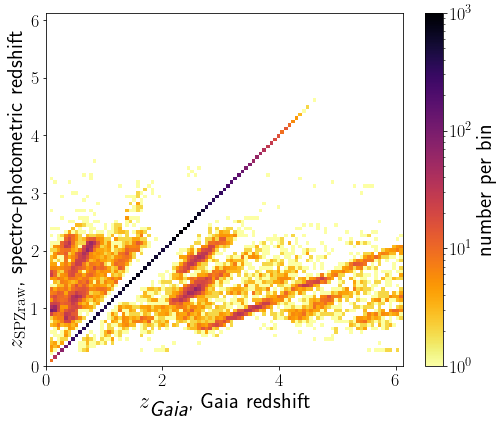

In [134]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_gaia_valid, z_spzx_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')
plt.ylabel(r'$z_\mathrm{SPZraw}$, spectro-photometric redshift')

try a smooth function

In [144]:
dz_min = dz_x
dz_max = dz_hi

frac_move = 1-(np.abs(dz_spzraw_gaia)-dz_min)/(dz_max-dz_min)
frac_move[frac_move<0] = 0
frac_move[frac_move>1] = 1

z_spzsmooth_valid = z_spzraw_valid + frac_move*dz_spzraw_gaia
dz_spzsmooth_sdss = (z_spzsmooth_valid - z_sdss_valid)/(1+z_sdss_valid)

Text(0, 0.5, '$z_\\mathrm{SPZraw}$, spectro-photometric redshift')

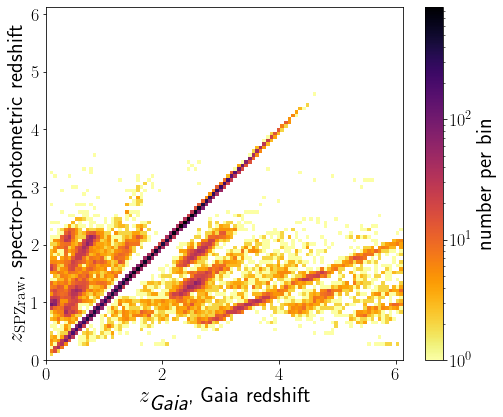

In [149]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6.5))
h = ax.hist2d(z_gaia_valid, z_spzsmooth_valid, bins=z_bins, cmin=1, cmap='inferno_r',
              norm=matplotlib.colors.LogNorm(),
              )
fig.colorbar(h[3], ax=ax, label='number per bin')

plt.xlabel(r'$z_\mathrm{\textit{Gaia}}$, Gaia redshift')
plt.ylabel(r'$z_\mathrm{SPZraw}$, spectro-photometric redshift')

In [88]:
G_max = 20.5
i_Gmax_valid = tab_spz_labeled['phot_g_mean_mag'][i_valid] < G_max

G_clean = 20.0
i_Gclean_valid = tab_spz_labeled['phot_g_mean_mag'][i_valid] < G_clean

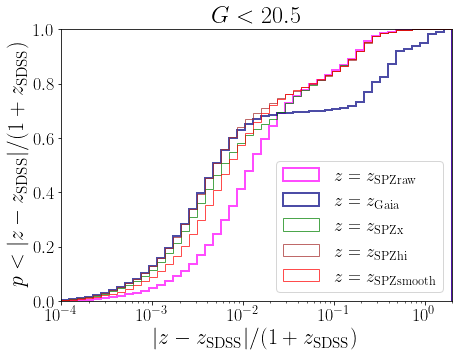

In [148]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)

plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_max}$', fontsize=24)
lw=1
alpha=0.7
plt.hist(abs(dz_spzraw_sdss[i_Gmax_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2, alpha=alpha,
         color='magenta', label=r'$z=z_\mathrm{SPZraw}$')
plt.hist(abs(dz_gaia_sdss[i_Gmax_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2, alpha=alpha,
         color='navy', label=r'$z=z_\mathrm{Gaia}$')
plt.hist(abs(dz_spzx_sdss[i_Gmax_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw, alpha=alpha,
         color='green', label=r'$z=z_\mathrm{SPZx}$')
plt.hist(abs(dz_spzhi_sdss[i_Gmax_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw, alpha=alpha,
         color='brown', label=r'$z=z_\mathrm{SPZhi}$')
plt.hist(abs(dz_spzsmooth_sdss[i_Gmax_valid]), bins=dz_bins_log, alpha=alpha,
         histtype='step', cumulative=True, density=True, lw=lw,
         color='red', label=r'$z=z_\mathrm{SPZsmooth}$')


plt.xlabel(r'$|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.ylabel(r'$p < |z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

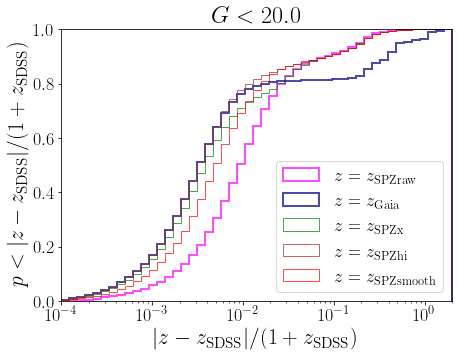

In [150]:
dz_bins_log = np.logspace(-4, np.log10(2), 50)

plt.figure(figsize=(7,5))
plt.title(rf'$G<{G_clean}$', fontsize=24)
lw=1
alpha=0.7
plt.hist(abs(dz_spzraw_sdss[i_Gclean_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2, alpha=alpha,
         color='magenta', label=r'$z=z_\mathrm{SPZraw}$')
plt.hist(abs(dz_gaia_sdss[i_Gclean_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=2, alpha=alpha,
         color='navy', label=r'$z=z_\mathrm{Gaia}$')
plt.hist(abs(dz_spzx_sdss[i_Gclean_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw, alpha=alpha,
         color='green', label=r'$z=z_\mathrm{SPZx}$')
plt.hist(abs(dz_spzhi_sdss[i_Gclean_valid]), bins=dz_bins_log, 
         histtype='step', cumulative=True, density=True, lw=lw, alpha=alpha,
         color='brown', label=r'$z=z_\mathrm{SPZhi}$')
plt.hist(abs(dz_spzsmooth_sdss[i_Gclean_valid]), bins=dz_bins_log, alpha=alpha,
         histtype='step', cumulative=True, density=True, lw=lw,
         color='red', label=r'$z=z_\mathrm{SPZsmooth}$')


plt.xlabel(r'$|z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.ylabel(r'$p < |z-z_\mathrm{SDSS}|/(1+z_\mathrm{SDSS})$')
plt.xscale('log')
plt.xlim(1e-4, 2)
plt.ylim(0,1)
plt.legend(loc='lower right')

In [129]:
G_maxs = [20.0, 20.5]

dz_threshs = [0.01, 0.1, 0.2]
for i in range(len(G_maxs)):
    print(f'G<{G_maxs[i]:.1f}')
    print()
    for iz, dz_thresh in enumerate(dz_threshs):

        i_insample = tab_spz_labeled['phot_g_mean_mag'][i_valid] < G_maxs[i]
        n_insample = np.sum(i_insample)
        
        f_outliers_spzraw = np.sum(np.abs(dz_spzraw_sdss[i_insample]) < dz_thresh) / n_insample
        f_outliers_gaia = np.sum(np.abs(dz_gaia_sdss[i_insample]) < dz_thresh) / n_insample
        f_outliers_spzx = np.sum(np.abs(dz_spzx_sdss[i_insample]) < dz_thresh) / n_insample
        
        print(f'Frac. of estimates with |dz|<{dz_thresh}:')
        print(f'SPZraw: {f_outliers_spzraw:.3f}')
        print(f'Gaia: {f_outliers_gaia:.3f}')
        print(f'SPZx: {f_outliers_spzx:.3f}')
        print()

G<20.0

Frac. of estimates with |dz|<0.01:
SPZraw: 0.493
Gaia: 0.753
SPZx: 0.709

Frac. of estimates with |dz|<0.1:
SPZraw: 0.905
Gaia: 0.812
SPZx: 0.905

Frac. of estimates with |dz|<0.2:
SPZraw: 0.943
Gaia: 0.822
SPZx: 0.943

G<20.5

Frac. of estimates with |dz|<0.01:
SPZraw: 0.403
Gaia: 0.621
SPZx: 0.580

Frac. of estimates with |dz|<0.1:
SPZraw: 0.835
Gaia: 0.699
SPZx: 0.835

Frac. of estimates with |dz|<0.2:
SPZraw: 0.911
Gaia: 0.722
SPZx: 0.911

